โจทย์: ให้ implement Q-learning RL agent เพื่อแก้ปัญหาโจทย์ Cliff-walking และ Taxi โดยใช้ Environment จาก Gymnasium

https://gymnasium.farama.org/environments/toy_text/cliff_walking/

https://gymnasium.farama.org/environments/toy_text/taxi/

โดยใช้ template ที่มีให้ใน https://colab.research.google.com/drive/1bh1jQNgPb4huUrjGq8VflPrlWeMosE18?usp=sharing

การส่งงาน: ให้ upload colab notebook ที่สมบูรณ์ขึ้น Mango Canvas


# ติดตั้ง library

In [ ]:
!pip install gymnasium -q

# Cliff-Walking Environment
This environment is part of the Toy Text environments which contains general information about the environment.

  
    Action Space      | Discrete(4)
    Observation Space | Discrete(48)
    import            | gymnasium.make("CliffWalking-v0")

**Cliff walking involves crossing a gridworld from start to goal while avoiding falling off a cliff.**



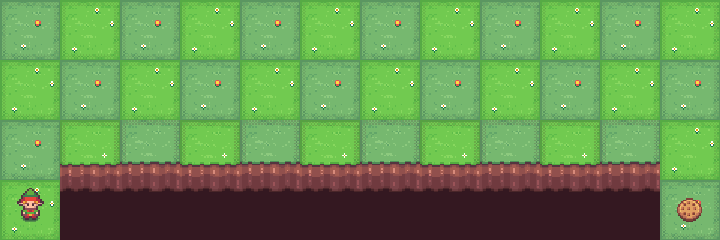

# Description
The game starts with the player at location [3, 0] of the 4x12 grid world with the goal located at [3, 11]. If the player reaches the goal the episode ends.

A cliff runs along [3, 1..10]. If the player moves to a cliff location it returns to the start location.

The player makes moves until they reach the goal.

Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction by Sutton and Barto [1].

The cliff can be chosen to be slippery (disabled by default) so the player may move perpendicular to the intended direction sometimes (see is_slippery).

With inspiration from: https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

Action Space
The action shape is (1,) in the range {0, 3} indicating which direction to move the player.

* 0: Move up

* 1: Move right

* 2: Move down

* 3: Move left

# Observation Space
There are 3 x 12 + 1 possible states. The player cannot be at the cliff, nor at the goal as the latter results in the end of the episode. What remains are all the positions of the first 3 rows plus the bottom-left cell.

The observation is a value representing the player’s current position as current_row * ncols + current_col (where both the row and col start at 0).

For example, the starting position can be calculated as follows: 3 * 12 + 0 = 36.

The observation is returned as an int().

# Starting State
The episode starts with the player in state [36] (location [3, 0]).

# Reward
Each time step incurs -1 reward, unless the player stepped into the cliff, which incurs -100 reward.

# Episode End
The episode terminates when the player enters state [47] (location [3, 11]).

#Information
step() and reset() return a dict with the following keys:

“p” - transition proability for the state.

As cliff walking is not stochastic, the transition probability returned always 1.0.

# Arguments
import gymnasium as gym
gym.make('CliffWalking-v1')

# References
[1] R. Sutton and A. Barto, “Reinforcement Learning: An Introduction” 2020. [Online]. Available: http://www.incompleteideas.net/book/RLbook2020.pdf

In [23]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

In [24]:
def render(env) -> None:
    img = env.render()
    if not hasattr(render, 'fig'):     # สร้าง figure และ axes แค่ครั้งเดียว
        render.fig, render.ax = plt.subplots()
        render.img_artist = render.ax.imshow(img, animated=True)
        plt.axis("off")                # ซ่อนแกน
        render.fig.canvas.draw_idle()  # เร่งการวาดภาพ
    render.img_artist.set_data(img)    # อัปเดตรูปภาพแทนการสร้างใหม่
    render.fig.canvas.draw_idle()      # ใช้ draw_idle() แทน redraw เต็มรูปแบบ
    display.display(render.fig, clear=False)
    display.clear_output(wait=True)

reward: -5088 at 10 episodes


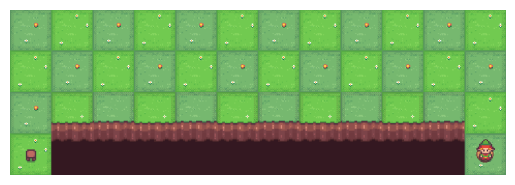

In [22]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")

# Q-learning Parameters
alpha = 0.1    # Learning rate
gamma = 0.99   # Discount factor
epsilon = 0.1  # Epsilon-greedy (10% random actions)
UP, RIGHT, DOWN, LEFT = 0, 1, 2, 3 # Action Mapping
Q_table = np.zeros((env.observation_space.n, env.action_space.n)) # Q-table (48 states x 4 actions)

def choose_action(state): # choose action by Q-learning (Epsilon-greedy)
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Random choose action (explore)
    else:
        return np.argmax(Q_table[state])  # Best action chosen (exploit)

episodes = 10
accumulated_reward = 0

for episode in tqdm(range(episodes), desc='Epochs'):
    state, info = env.reset()
    done = False
    while not done:
        action = choose_action(state)  # Policy: epsilon-greedy
        next_state, reward, terminated, truncated, info = env.step(action)
        # Update Q-table according to Q-learning rule
        Q_table[state, action] = (1 - alpha) * Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[next_state]))
        # Collect reward
        accumulated_reward += reward
        # Snapshot and show result
        render(env)
        # Ending condition
        if terminated or truncated:
            done = True
            state, info = env.reset()
        else:
            state = next_state

display.clear_output(wait=True)
env.close()

print(f"reward: {accumulated_reward} at {episodes} episodes")



# Taxi environment
This environment is part of the Toy Text environments which contains general information about the environment.

    Action Space      | Discrete(6)
    Observation Space | Discrete(500)
    import            | gymnasium.make("Taxi-v3")

**The Taxi Problem involves navigating to passengers in a grid world, picking them up and dropping them off at one of four locations.**



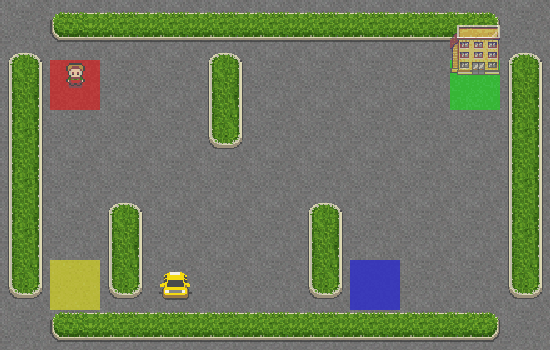

# Description
There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations.

The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends.

The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and for each step where another reward is not received.

Map:

    +---------+
    |R: | : :G|
    | : | : : |
    | : : : : |
    | | : | : |
    |Y| : |B: |
    +---------+

From “Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition” by Tom Dietterich [1].

# Action Space
The action shape is (1,) in the range {0, 5} indicating which direction to move the taxi or to pickup/drop off passengers.

* 0: Move south (down)

* 1: Move north (up)

* 2: Move east (right)

* 3: Move west (left)

* 4: Pickup passenger

* 5: Drop off passenger

# Observation Space
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

Destination on the map are represented with the first letter of the color.

Passenger locations:

* 0: Red

* 1: Green

* 2: Yellow

* 3: Blue

* 4: In taxi

Destinations:

* 0: Red

* 1: Green

* 2: Yellow

* 3: Blue

An observation is returned as an int() that encodes the corresponding state, calculated by ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.

# Starting State
The initial state is sampled uniformly from the possible states where the passenger is neither at their destination nor inside the taxi. There are 300 possible initial states: 25 taxi positions, 4 passenger locations (excluding inside the taxi) and 3 destinations (excluding the passenger’s current location).

# Rewards
-1 per step unless other reward is triggered.

+20 delivering passenger.

-10 executing “pickup” and “drop-off” actions illegally.

An action that results a noop, like moving into a wall, will incur the time step penalty. Noops can be avoided by sampling the action_mask returned in info.

# Episode End
The episode ends if the following happens:

Termination: 1. The taxi drops off the passenger.

Truncation (when using the time_limit wrapper): 1. The length of the episode is 200.

# Information
step() and reset() return a dict with the following keys:

p - transition proability for the state.

action_mask - if actions will cause a transition to a new state.

As taxi is not stochastic, the transition probability is always 1.0. Implementing a transitional probability in line with the Dietterich paper (‘The fickle taxi task’) is a TODO.

For some cases, taking an action will have no effect on the state of the episode. In v0.25.0, info["action_mask"] contains a np.ndarray for each of the actions specifying if the action will change the state.

To sample a modifying action, use action = env.action_space.sample(info["action_mask"]) Or with a Q-value based algorithm action = np.argmax(q_values[obs, np.where(info["action_mask"] == 1)[0]]).

# Arguments
    import gymnasium as gym
    gym.make('Taxi-v3')

array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]], dtype=uint8)
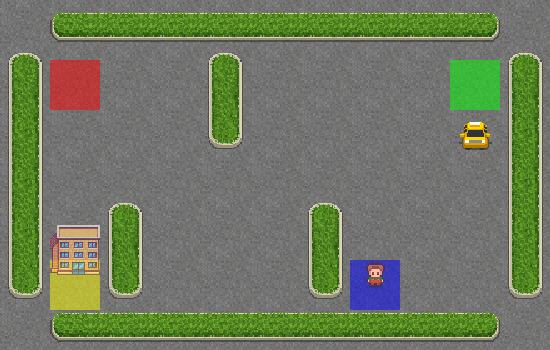

Epochs: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

reward: -10 at 10 episodes


In [4]:
env = gym.make("Taxi-v3", render_mode="rgb_array")

# Parameters for Q-learning
alpha = 0.1    # Learning rate
gamma = 0.9    # Discount factor
epsilon = 0.1  # Exploration rate
num_states = env.observation_space.n
num_actions = env.action_space.n
Q_table = np.zeros((num_states, num_actions))

def select_action(state): # Policy ε-greedy
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Random action (explore)
    return np.argmax(Q_table[state, :])   # Best action chosen (exploit)

observation, info = env.reset()
episodes = 10
accumulated_reward = 0

for episode in tqdm(range(episodes), desc='Epochs'):
    state = observation  # Current state
    action = select_action(state)  # Choose action
    next_state, reward, terminated, truncated, info = env.step(action) # Environment Process

    # Update Q-table by Q-learning equation
    Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[next_state, :]) - Q_table[state, action])
    accumulated_reward += reward

    display.clear_output(wait=True)
    display.display(env.render())

    if terminated or truncated:
        observation, info = env.reset()
    else:
        observation = next_state
env.close()

print(f"reward: {accumulated_reward} at {episodes} episodes")
